# This notebook is my work on Titanic dataset from kaggle.com

In [1]:
# imports for data visualization and preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
# reading the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## So the plan is visualize and preprocess data from train set and do same preprocessing to test set. Then train different machine learning models on training test, pick the best two (competition uses accuracy score as evaluation so that's what I'm going to us as well), try to tune them a bit hoping to get a better score, use the best one on test set and submit the result

In [3]:
# check general info on the datasets
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### "Cabin" columns in both train and test datasets have too many values missing. I will just drop them out. 
### "SibSP" and "Parch" columns basically show family members travelling with the passenger so I'll create column "Family" instead of them with 0s if no family members were on board and 1s if there were any family member. Then I'll drop "SibSP" and "Parch" columns as well

In [5]:
# creating new column Family using list comprehention
train["Family"] = [0 if train["SibSp"][i] == 0 and train["Parch"][i] == 0 else 1 for i in range(len(train["Parch"]))]
test["Family"] = [0 if test["SibSp"][i] == 0 and test["Parch"][i] == 0 else 1 for i in range(len(test["Parch"]))]

# dropping columns out
train.drop(["Cabin","SibSp","Parch"], axis=1, inplace=True)
test.drop(["Cabin","SibSp","Parch"], axis=1, inplace=True)

### Now I need to deal with missing values.
### "Embarked" column on train set has only two values missing. I think I can fill it with the most popular port of embarkment

<AxesSubplot:xlabel='Embarked', ylabel='count'>

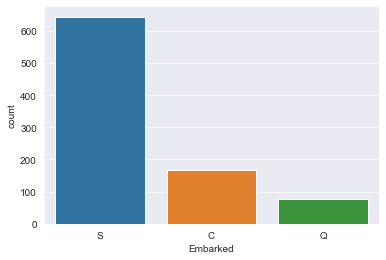

In [6]:
# countplot to find out which port was the most popular to embark from
sns.countplot(train["Embarked"])

### According to the graph it would be pretty safe to put Southampton as port of embarkment instead of two missing values as it was by far the most popular embarkment spot

In [7]:
train["Embarked"].fillna("S", inplace=True)

### Now to the "Age" column. 
### Normally, I would put mean age values instead of missing ones. But in this case I'll try it a little bit different

In [8]:
# mean age
train_meanage = train["Age"].mean()
test_meanage = test["Age"].mean()
print(f"Mean age in train dataset is {train_meanage} years old")
print(f"Mean age in test dataset is {test_meanage} years old")

Mean age in train dataset is 29.69911764705882 years old
Mean age in test dataset is 30.272590361445783 years old


### So the mean age is around 30 years but this number is a bit different for different classes. The idea is that people of the 1st class were probably older than people of the 2nd or 3rd class

In [9]:
train["Age"].groupby(train["Pclass"]).mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [10]:
test["Age"].groupby(test["Pclass"]).mean()

Pclass
1    40.918367
2    28.777500
3    24.027945
Name: Age, dtype: float64

### It's true! People in the 1st class were older than of the 2nd and the 3rd class. Let's write a function so we could fill in the blanks accordingly

In [11]:
def mean_age_train(age_pclass):     # a function would take two columns ("Age" and "Pclass") as parameters
    
    age = age_pclass[0]
    pclass = age_pclass[1]
    
    # if the value is missing
    if pd.isnull(age):
        
        # if 1st class
        if pclass == 1:
            return 38
        
        # if 2nd class
        elif pclass == 2:
            return 30
        
        # if 3rd class
        else:
            return 25
        
    # if no values missing    
    else:
        return age
    
    
# and almost the same for test set
def mean_age_test(age_pclass):     # a function would take two columns ("Age" and "Pclass") as parameters
    
    age = age_pclass[0]
    pclass = age_pclass[1]
    
    # if the value is missing
    if pd.isnull(age):
        
        # if 1st class
        if pclass == 1:
            return 41
        
        # if 2nd class
        elif pclass == 2:
            return 29
        
        # if 3rd class
        else:
            return 24
        
    # if no values missing    
    else:
        return age
    
    
# now applying those functions
train["Age"] = train[["Age","Pclass"]].apply(mean_age_train, axis=1)
test["Age"] = test[["Age","Pclass"]].apply(mean_age_test, axis=1)

### Now there is only one missing values left in "Fare" column of test dataset. I think I'll same technique as I used for "Age" column. Put a mean value according to the class instead of missing one.

In [12]:
# mean fare values grouped by class
test["Fare"].groupby(test["Pclass"]).mean()

Pclass
1    94.280297
2    22.202104
3    12.459678
Name: Fare, dtype: float64

In [13]:
# check what class the passenger with missing value in "Fare" column used
test[test["Fare"].isnull() == True]

,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Family
152,1044,3,"Storey, Mr. Thomas",male,60.5,3701,NaN,S,0


In [13]:
# so this person used the 3rd class
test["Fare"].fillna(12.46, inplace=True)

### Let's check out our datasets again

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   Ticket       891 non-null    object 
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
 9   Family       891 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   Ticket       418 non-null    object 
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    object 
 8   Family       418 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 29.5+ KB


### No missing values - good!
### Now I'll drop out several columns. "PassangerId" - no use in that, "Name" - I could get titles out of that but I don't see how that would be usefull. We already have "Sex" column and I feel like titles and sex will be to similar. "Ticket" - same thing. I think it would be too similar to "Pclass" column.

In [16]:
# dropping the columns mentioned above out
train.drop(["PassengerId","Name","Ticket"], axis=1, inplace=True)
test.drop(["PassengerId","Name","Ticket"], axis=1, inplace=True)

### Let's visualize survival rate by different sexes, classes, embarkment ports and those who had relatives

<AxesSubplot:xlabel='Family', ylabel='count'>

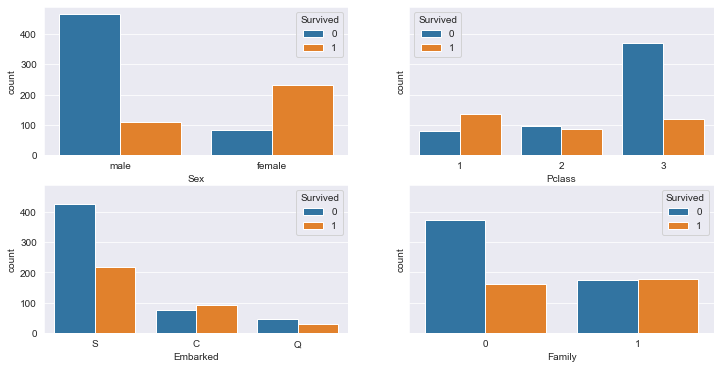

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6), sharey=True)
sns.countplot(x="Sex", hue="Survived", data=train, ax=axes[0][0])
sns.countplot(x="Pclass", hue="Survived", data=train, ax=axes[0][1])
sns.countplot(x="Embarked", hue="Survived", data=train, ax=axes[1][0])
sns.countplot(x="Family", hue="Survived", data=train, ax=axes[1][1])

### According to the graphs, we can see that there were 2,5 times more females survived than males(females were one of the first ones to board lifeboats), more than half of passengers of the 1st class survived (they occupied top decks of the ship). Most of the dead and survived embarked in Southampton (makes sense considering it was the most popular port of embarkment) and half of those who had family members on board survived.

## I think it's all set for machine learning part now!

### Let's see the features we're working with again

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  891 non-null    object 
 6   Family    891 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   Fare      418 non-null    float64
 4   Embarked  418 non-null    object 
 5   Family    418 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 19.7+ KB


### OK, I'll have to convert categorical data ("Embarked" and "Sex" columns) into numerical, scale the data. I want to use cross validation with accuracy score as evaluation metric. Also I'll try different machine learning techniques for classification (logistic regression, decision tree, random forest, knn, support vector machines, adaptive boosting and extreme gradient boosting). Then I'll do grid search for tuning top 2 models trying to get them to perform better.

In [20]:
# imports and variables for ml
from sklearn.preprocessing import LabelEncoder, StandardScaler  # for labeling and scaling

# cross validation
from sklearn.model_selection import cross_val_score

# evaluation
from sklearn.metrics import accuracy_score

# tunning
from sklearn.model_selection import GridSearchCV

# logistic regression
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()

# knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# decision tree
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

# random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

# support vector machines
from sklearn.svm import SVC
sv = SVC()

# adaptive boosting
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(base_estimator=dtree)

# extreme gradient boosting
from xgboost import XGBClassifier
xgb = XGBClassifier()

### Label and scale data first

In [21]:
# split train dataset into X and y
X = train.drop("Survived", axis=1)
y = train["Survived"]

# labeling
columns = ["Sex","Embarked"]
for column in columns:
    X[column] = LabelEncoder().fit_transform(X[column])
    test[column] = LabelEncoder().fit_transform(test[column])

# scaling
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
test = scaler.transform(test)

### I want to use a for loop to train every model and print out mean accuracy score

In [22]:
models = {
    "Logistic regression":logr,
    "K-Nearest Neighbors":knn,
    "Decision tree":dtree,
    "Random forest":rfc,
    "Support Vector Machines":sv,
    "Adaptive boosting":adaboost,
    "Extreme gradient boosting":xgb
}

for variable, model in models.items():
    print(f"{variable}'s mean accuracy score is {cross_val_score(model, X, y, cv=10, scoring='accuracy').mean()}")

Logistic regression's mean accuracy score is 0.7901498127340825
K-Nearest Neighbors's mean accuracy score is 0.802521847690387
Decision tree's mean accuracy score is 0.7890886392009987
Random forest's mean accuracy score is 0.8070287141073658
Support Vector Machines's mean accuracy score is 0.8125468164794007
Adaptive boosting's mean accuracy score is 0.802521847690387
Extreme gradient boosting's mean accuracy score is 0.8126342072409487


### So the best two are XGBoost and Support vector machines. But Support vector machines is very slow (Seriously, I tried to tune it once and it took way too much time for almost no improvement) so I think I'll use XGBoost and Random forest this time.
### I want to try to tune them to see if I can make them perform better. Using Grid search for that.

In [67]:
# start with xgboost parameters
xgb_params = {
    
    "learning_rate":[1,0.1,0.01,0.001],
    "n_estimators":[100,150,300,600,1000],
    "max_depth":range(3,10,2),
    "min_child_weight":range(1,6,2),
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001]
}

xgb_grid = GridSearchCV(estimator=XGBClassifier(),
                       param_grid=xgb_params,
                       cv=10, scoring="accuracy")
xgb_grid.fit(X,y)

# best score and parameters
print(f"Best score is {xgb_grid.best_score_}")
print(f"Best parameters are {xgb_grid.best_params_}")

Best score is 0.8395630461922596
Best parameters are {'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300}


In [24]:
# and random forest
rfc_params = {
    "criterion":["gini","entropy"],
    "n_estimators":[100,150,300,600,1000],
    "max_depth":[None,10,20,30,40,50,60,70,80,90,100],
    "min_samples_leaf":[1,2,4],
    "min_samples_split":[2,5,10],
    "max_features":["auto","sqrt","log2"],
    "bootstrap":[True,False]
}

rfc_grid = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=rfc_params,
                       cv=10, scoring="accuracy")
rfc_grid.fit(X,y)

# best score and parameters
print(f"Best score is {rfc_grid.best_score_}")
print(f"Best parameters are {rfc_grid.best_params_}")

Best score is 0.8373033707865168
Best parameters are {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


### It's good I didn't hold my breath for that. Took a bit of a time :-)
### Now I'll set XGBoost with optimal parameters and do predictions

In [23]:
opt_xgb = XGBClassifier(gamma=0.001,
                       learning_rate=0.1,
                       max_depth=5,
                       min_child_weight=5,
                       n_estimators=300)

In [25]:
# train the model
opt_xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
# predictions
predict = opt_xgb.predict(test)

### I should've saved "PassengerID" column from the test data set for submission. Now, I'll have to read .csv file again, then I'll take that column and concat it with predictions and save the new dataframe into submission.csv file.

In [31]:
# reading test.csv again
for_submission = pd.read_csv("test.csv")

# predictions into dataframe
prediction_df = pd.DataFrame(data=predict, columns=["Survived"])

# submission dataframe
submission = pd.concat([for_submission["PassengerId"], prediction_df], axis=1)

# submission dataframe into .csv file
submission.to_csv("submission.csv", index=False)

## This file was submitted to kaggle.com with the score of 0.76315 which I think a decent result for my first competition!

#### Any tips, hints, ideas, etc. to improve the score are very welcome!

## PS 
### I decided to submit predictions of the tuned random forest as well. The result turned out to be slightly better - 0.77990. But I still think Extreme gradient boosting would be a better option because it took much less time tunning it than Random forest. 

In [33]:
# optimal parameters for random forest
opt_rfc = RandomForestClassifier(criterion="entropy",
                                max_features="log2",
                                bootstrap=True,
                                max_depth=30,
                                min_samples_leaf=2,
                                min_samples_split=5,
                                n_estimators=100)

# training the model
opt_rfc.fit(X,y)

# predictions into dataframe
pred = pd.DataFrame(data=opt_rfc.predict(test), columns=["Survived"])

# submission dataframe
rfc_pred = pd.concat([for_submission["PassengerId"], pred], axis=1)

# submission dataframe to .csv file
rfc_pred.to_csv("rfc_pred.csv", index=False)